In [2]:
import numpy as np
import re
import pickle 
import time
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files
from sklearn.metrics import classification_report
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC


from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
#Textblob for Sentiment Analysis
def sentiment_blob(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

# spelling correction for given input text
def spell_correction_blob(text):
    try:
        return TextBlob(text).correct()
    except:
        return None

# cleans input text.
def text_cleaner(text):
    text = text.strip()
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'^br$', ' ', text)
    text = re.sub(r'\s+br\s+',' ',text)
    text = re.sub(r'\s+[a-z]\s+', ' ',text)
    text = re.sub(r'^b\s+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]+', ' ',text)
    text = text.strip()

    return text

def plot_roc_curve(fpr, tpr):
    """
    Plots a ROC curve given the false positve rate (fpr) and 
    true postive rate (tpr) of a classifier.
    """
    # Plot ROC curve
    figure = plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Guessing')
    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

def preprocess_text(text):
    text = text_cleaner(text)
    text = lemmatize_text(text)

    return text

def get_sentiment(model,text):
    sample = [preprocess_text(text)]
    sample = vectorizer.transform(sample).toarray()
    sentiment = model.predict_proba(sample)
    
    return ('Positive', sentiment[0][1]) if sentiment[0][0] < sentiment[0][1] else ('Negative', sentiment[0][0])



In [4]:
# read data
raw_df = pd.read_csv("hotel_reviews_labeled.csv")

raw_df

,hotel_name,hotel_location,review_title,review_pos,review_neg,review_date,review_country,num_reviews_by_reviewer,reviewer_name,review_rating,review_tags,label
0,Siam Eco Hostel,"13.75308373,100.53145603",“Nice hostel in a great location”,"it’s really well located, the stuff is nice an...","the breakfast could be better, but I guess it’...",2022-04-2T00:00:00,Germany,15,Karina,9.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
1,Siam Eco Hostel,"13.75308373,100.53145603",“Relaxed hostel with great staff and great com...,The staff was superfriendly and helpful and th...,Don't expect too much from the provided breakf...,2022-03-31T00:00:00,Netherlands,4,Pleun,9.0,"Leisure trip,Group,Bed in 6-Bed Mixed Dormitor...",1.0
2,Siam Eco Hostel,"13.75308373,100.53145603",“Great hostel in convenient location”,"really nice reception staff, who let us check ...","Breakfast was a little small, but was fine",2022-03-6T00:00:00,United Kingdom,7,Maia,10.0,"Leisure trip,Group,Economy Quadruple Room with...",1.0
3,Siam Eco Hostel,"13.75308373,100.53145603",Exceptional,"Clean, nice and calm space. Breakfast was some...",No Negative,2022-03-1T00:00:00,Norway,1,Emmeli,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
4,Siam Eco Hostel,"13.75308373,100.53145603",“perfect place”,everything is perfect: women in reception so n...,No Negative,2022-02-24T00:00:00,Lithuania,76,Sooofija,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
156088,ZEN Rooms Bukit Merah,"1.27264209,103.82767699",Poor,No Positive,No Negative,2019-06-4T00:00:00,South Korea,1,Hasung,3.3,"Business trip,Solo traveller,Superior Twin Roo...",0.0
156089,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Pleasant,The tenant lady is helpful accomodating my req...,The music at the fish pond during all night an...,2022-02-28T00:00:00,Singapore,8,Geraldine,6.0,"Leisure trip,Family with young children,Chalet...",1.0
156090,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Poor,"Place is big and roomy, near the sea and other...",Poorly maintained and dirty. No formal checkin...,2022-03-15T00:00:00,Singapore,1,Chun,3.0,"Business trip,Solo traveller,Chalet with Sea V...",0.0
156091,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Very poor,Winston was a helpful housekeeping ..even help...,A1 unit Haunted room of masterbedroom n room 3...,2022-01-24T00:00:00,Singapore,1,Nor,2.0,"Leisure trip,Family with young children,Chalet...",0.0


In [5]:
df = raw_df.copy()

In [6]:
df_title = df.groupby(['review_title']).max().reset_index()
display(df_title)

<ipython-input-6-8e19dc9f4921>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  df_title = df.groupby(['review_title']).max().reset_index()


,review_title,hotel_name,hotel_location,review_date,num_reviews_by_reviewer,reviewer_name,review_rating,review_tags,label
0,Disappointing,lebua at State Tower - SHA Extra Plus,"34.73433440,135.49904913",2022-04-1T00:00:00,154,อารียา,4.6,"With a pet,Leisure trip,Solo traveller,Studio ...",0.0
1,Exceptional,ゲストハウス888 女性専用ドミトリー,"34.74725725,135.49790034",2022-04-3T00:00:00,482,🐺,10.0,"With a pet,Solo traveller,Twin Room,Stayed 1 n...",1.0
2,Fabulous,twothree a homely hotel - SHA Extra Plus,"34.73857884,135.48437208",2022-02-23T00:00:00,389,龙猫233,8.8,"Solo traveller,Twin Room,Stayed 4 nights,Submi...",1.0
3,Good,ゲストハウス888 女性専用ドミトリー,"34.75761678,135.49836382",2022-04-3T00:00:00,482,🤪😃,7.9,"With a pet,Leisure trip,Solo traveller,Superio...",1.0
4,Okay,remm Shin-Osaka,"34.73506620,135.56596756",2021-10-25T00:00:00,136,齊,5.8,"Solo traveller,Superior Twin Room,Stayed 1 nig...",1.0
...,...,...,...,...,...,...,...,...,...
41341,“😍”,Resort V - MRT Huai Khwang,"13.78548300,100.57026500",2019-07-23T00:00:00,23,Ye,10.0,"Leisure trip,Family with young children,Deluxe...",NaN
41342,“😍😍”,Hotel Ordinary Bangkok,"13.75625700,100.54280800",2020-12-3T00:00:00,5,Felimon,10.0,"Leisure trip,Solo traveller,Deluxe King Room,S...",NaN
41343,“😔”,Ibis Budget Singapore Pearl (SG Clean),"1.31156100,103.87929000",2019-10-24T00:00:00,5,Abdul,5.8,"Leisure trip,Family with young children,Deluxe...",NaN
41344,“😡😡”,Hotel 81 Bugis - SG Clean,"1.29696527,103.85570973",2022-03-6T00:00:00,3,Nay,1.0,"Leisure trip,Couple,Standard Double Room,Staye...",NaN


In [7]:
df_title.dropna(inplace=True)
df_title['review_title'] = df_title['review_title'].apply(text_cleaner) # cleans data

df_title = df_title.groupby('review_title').mean().reset_index() # cleans data

df_title['blob'] = df_title['review_title'].apply(sentiment_blob) # apply TextBlob sentiment analysis
df_title['polarity'] = df_title['blob'].apply(lambda x: x[0]) # extract polarity score from blob column
df_title['subjectivity'] = df_title['blob'].apply(lambda x: x[1]) # extract subjectivity score from blob coumn
df_title['word_count'] = df_title['review_title'].apply(lambda x: len(x.strip().split(' ')))

df_title['review_title'] = df_title['review_title'].apply(lambda x: None if len(x) <2 else x) # reviews with a single space

df_title.dropna(inplace=True)

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

df_title['review_title'] = df_title['review_title'].apply(lemmatize_text)
df_title['label'] = df_title['label'].apply(lambda x: int(x))

df_title.dropna(inplace=True)

display(df_title)

,review_title,num_reviews_by_reviewer,review_rating,label,blob,polarity,subjectivity,word_count
1,1 it all began with confirmed reservation give...,5.0,2.5,1,"(0.4, 1.0)",0.400000,1.00000,14
2,1 night of complete rest after arriving in thai,20.0,9.0,1,"(0.1, 0.4)",0.100000,0.40000,9
3,1 night stay at amara good for those who love ...,6.0,5.8,1,"(0.6, 0.6000000000000001)",0.600000,0.60000,13
4,1 of the best hotel have been in,2.0,9.0,1,"(1.0, 0.3)",1.000000,0.30000,8
5,1 review halal cert for breakfast 2ndly to pro...,2.0,10.0,0,"(-0.016666666666666666, 0.0)",-0.016667,0.00000,14
...,...,...,...,...,...,...,...,...
30789,you won regret it good neighborhood in bkk,23.0,8.0,1,"(0.7, 0.6000000000000001)",0.700000,0.60000,8
30790,your front desk staff elaine hope spelled corr...,40.0,8.0,0,"(-0.125, 1.0)",-0.125000,1.00000,19
30791,your re doing great keep going,1.0,10.0,1,"(0.8, 0.75)",0.800000,0.75000,6
30792,zed hostel is nice place to stay we chose the ...,3.0,10.0,1,"(0.3875, 0.66875)",0.387500,0.66875,22


In [8]:
df_neg = df_title[(df_title['subjectivity'] > 0.5) & (df_title['label'] == 0)]
df_pos = df_title[(df_title['subjectivity'] > 0.5) & (df_title['label'] == 1)]

In [9]:
print(len(df_neg))
print(len(df_pos))

1736
20775


In [10]:
# Downsample positive
df_pos = df_pos.sample(len(df_neg))

In [11]:
df_data = pd.concat([df_neg, df_pos])
df_data.rename(columns={'label':'y_true'}, inplace=True)

display(df_data)

,review_title,num_reviews_by_reviewer,review_rating,y_true,blob,polarity,subjectivity,word_count
20,16 day of uncomfortable stay,2.0,3.8,0,"(-0.5, 1.0)",-0.500000,1.000000,5
24,1st time in 2021 facing esplanade gr8 view thi...,1.0,8.0,0,"(-0.375, 0.625)",-0.375000,0.625000,16
39,2 star room with 5 star corridor it wa the mos...,3.0,5.0,0,"(-0.125, 0.625)",-0.125000,0.625000,16
47,3 star hotel not quite the ryokan unfortunately,7.0,6.3,0,"(-0.5, 1.0)",-0.500000,1.000000,8
60,4 hotel seriously,14.0,3.0,0,"(-0.3333333333333333, 0.6666666666666666)",-0.333333,0.666667,3
...,...,...,...,...,...,...,...,...
16693,kazu made our stay truly special thank you,6.0,10.0,1,"(0.35714285714285715, 0.5714285714285714)",0.357143,0.571429,8
629,amazing design hotel,51.0,8.0,1,"(0.6000000000000001, 0.9)",0.600000,0.900000,3
15302,incredible value,11.0,8.8,1,"(0.9, 0.9)",0.900000,0.900000,2
11245,great for 1 or 2 day,58.0,8.0,1,"(0.8, 0.75)",0.800000,0.750000,6


In [12]:
X, y = df_data['review_title'].reset_index(drop=True), df_data['y_true'].reset_index(drop=True)

print('Total number of rows: ', df_data.shape[0])
print('Total number of positive reviews: ', y.sum())
print('Percentage of positive reivews:', y.sum()/df_data.shape[0])

Total number of rows:  3472
Total number of positive reviews:  1736
Percentage of positive reivews: 0.5


In [13]:
vectorizer = TfidfVectorizer(max_features = 500,stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(X).toarray()

X.shape


(3472, 500)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2879, random_state = 1)

print(len(X_test))

1000


train score: 0.9340614886731392
test score: 0.892


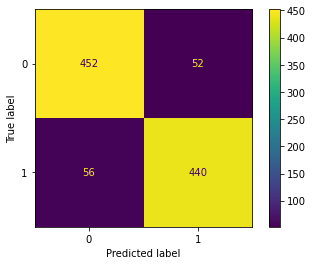

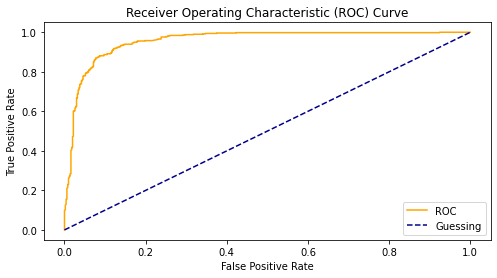

              precision    recall  f1-score   support

    Negative       0.89      0.90      0.89       504
    Positive       0.89      0.89      0.89       496

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

Total time to classify 1000 records: 0.0010008811950683594 seconds
Time to classify each record: 1.0008811950683595e-06 seconds


In [18]:

lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)

# sent_pred = model.predict(text_test)
print("train score:", lr_model.score(X_train,y_train))
print("test score:", lr_model.score(X_test,y_test))

from sklearn.metrics import ConfusionMatrixDisplay

y_preds = lr_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

# Make predictions with probabilities
y_probs = lr_model.predict_proba(X_test)

y_probs_positive = y_probs[:, 1]
# Caculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)
# Create a function for plotting ROC curves

plot_roc_curve(fpr, tpr)

target_names = ['Negative', 'Positive']

print(classification_report(y_test, y_preds, target_names=target_names))

start = time.time()

lr_model.predict(X_test)

end = time.time()

print(f"Total time to classify {len(X_test)} records: {end - start} seconds")
print(f"Time to classify each record: {((end - start)/len(X_test))} seconds")

train score: 0.9300161812297735
test score: 0.91


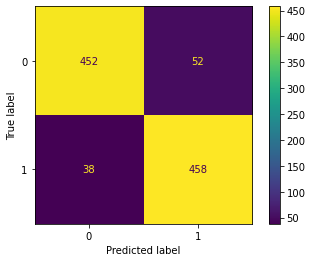

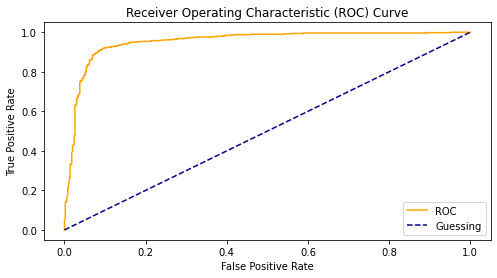

              precision    recall  f1-score   support

    Negative       0.92      0.90      0.91       504
    Positive       0.90      0.92      0.91       496

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

Total time to classify 1000 records: 0.07597661018371582 seconds
Time to classify each record: 7.597661018371582e-05 seconds


In [ ]:
bagging_clf = BaggingClassifier(base_estimator=LogisticRegression(),n_estimators=15, random_state=42).fit(X_train,y_train)

print("train score:", bagging_clf.score(X_train,y_train))
print("test score:", bagging_clf.score(X_test,y_test))

y_preds = bagging_clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

# Make predictions with probabilities
y_probs = bagging_clf.predict_proba(X_test)

y_probs_positive = y_probs[:, 1]
# Caculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)
# Create a function for plotting ROC curves

plot_roc_curve(fpr, tpr)

target_names = ['Negative', 'Positive']

print(classification_report(y_test, y_preds, target_names=target_names))

start = time.time()

bagging_clf.predict(X_test)

end = time.time()

print(f"Total time to classify {len(X_test)} records: {end - start} seconds")
print(f"Time to classify each record: {((end - start)/len(X_test))} seconds")

In [16]:
def get_pred(text):
    sample = [preprocess_text(text)]
    sample = vectorizer.transform(sample).toarray()
    sentiment = lr_model.predict_proba(sample)
    
    return 1 if sentiment[0][0] < sentiment[0][1] else 0


sid = SentimentIntensityAnalyzer()

def get_ensemble_sentiment(text):
    vader_sentiment = 1 if sid.polarity_scores(text)['pos'] > sid.polarity_scores(text)['neg'] else 0
    textblob_sentiment = 1 if TextBlob(text).sentiment[0] > 0 else 0
    ml_sentiment = get_pred(text)
    sum = vader_sentiment + textblob_sentiment + ml_sentiment

    return 1 if sum >= 2 else 0

get_ensemble_sentiment('best hotel ever')


1

In [17]:
df_pred = raw_df.copy().dropna().reset_index(drop=True)

display(df_pred)

,hotel_name,hotel_location,review_title,review_pos,review_neg,review_date,review_country,num_reviews_by_reviewer,reviewer_name,review_rating,review_tags,label
0,Siam Eco Hostel,"13.75308373,100.53145603",“Nice hostel in a great location”,"it’s really well located, the stuff is nice an...","the breakfast could be better, but I guess it’...",2022-04-2T00:00:00,Germany,15,Karina,9.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
1,Siam Eco Hostel,"13.75308373,100.53145603",“Relaxed hostel with great staff and great com...,The staff was superfriendly and helpful and th...,Don't expect too much from the provided breakf...,2022-03-31T00:00:00,Netherlands,4,Pleun,9.0,"Leisure trip,Group,Bed in 6-Bed Mixed Dormitor...",1.0
2,Siam Eco Hostel,"13.75308373,100.53145603",“Great hostel in convenient location”,"really nice reception staff, who let us check ...","Breakfast was a little small, but was fine",2022-03-6T00:00:00,United Kingdom,7,Maia,10.0,"Leisure trip,Group,Economy Quadruple Room with...",1.0
3,Siam Eco Hostel,"13.75308373,100.53145603",Exceptional,"Clean, nice and calm space. Breakfast was some...",No Negative,2022-03-1T00:00:00,Norway,1,Emmeli,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
4,Siam Eco Hostel,"13.75308373,100.53145603",“perfect place”,everything is perfect: women in reception so n...,No Negative,2022-02-24T00:00:00,Lithuania,76,Sooofija,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
142291,ZEN Rooms Bukit Merah,"1.27264209,103.82767699",Poor,No Positive,No Negative,2019-06-4T00:00:00,South Korea,1,Hasung,3.3,"Business trip,Solo traveller,Superior Twin Roo...",0.0
142292,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Pleasant,The tenant lady is helpful accomodating my req...,The music at the fish pond during all night an...,2022-02-28T00:00:00,Singapore,8,Geraldine,6.0,"Leisure trip,Family with young children,Chalet...",1.0
142293,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Poor,"Place is big and roomy, near the sea and other...",Poorly maintained and dirty. No formal checkin...,2022-03-15T00:00:00,Singapore,1,Chun,3.0,"Business trip,Solo traveller,Chalet with Sea V...",0.0
142294,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Very poor,Winston was a helpful housekeeping ..even help...,A1 unit Haunted room of masterbedroom n room 3...,2022-01-24T00:00:00,Singapore,1,Nor,2.0,"Leisure trip,Family with young children,Chalet...",0.0


In [18]:

df_pred['pred'] = df_pred['review_title'].apply(get_ensemble_sentiment)

display(df_pred)

y_pred = df_pred['pred']
y_true = df_pred['label']
accuracy_score(y_true, y_pred)

,hotel_name,hotel_location,review_title,review_pos,review_neg,review_date,review_country,num_reviews_by_reviewer,reviewer_name,review_rating,review_tags,label,pred
0,Siam Eco Hostel,"13.75308373,100.53145603",“Nice hostel in a great location”,"it’s really well located, the stuff is nice an...","the breakfast could be better, but I guess it’...",2022-04-2T00:00:00,Germany,15,Karina,9.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0,1
1,Siam Eco Hostel,"13.75308373,100.53145603",“Relaxed hostel with great staff and great com...,The staff was superfriendly and helpful and th...,Don't expect too much from the provided breakf...,2022-03-31T00:00:00,Netherlands,4,Pleun,9.0,"Leisure trip,Group,Bed in 6-Bed Mixed Dormitor...",1.0,1
2,Siam Eco Hostel,"13.75308373,100.53145603",“Great hostel in convenient location”,"really nice reception staff, who let us check ...","Breakfast was a little small, but was fine",2022-03-6T00:00:00,United Kingdom,7,Maia,10.0,"Leisure trip,Group,Economy Quadruple Room with...",1.0,1
3,Siam Eco Hostel,"13.75308373,100.53145603",Exceptional,"Clean, nice and calm space. Breakfast was some...",No Negative,2022-03-1T00:00:00,Norway,1,Emmeli,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0,1
4,Siam Eco Hostel,"13.75308373,100.53145603",“perfect place”,everything is perfect: women in reception so n...,No Negative,2022-02-24T00:00:00,Lithuania,76,Sooofija,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142291,ZEN Rooms Bukit Merah,"1.27264209,103.82767699",Poor,No Positive,No Negative,2019-06-4T00:00:00,South Korea,1,Hasung,3.3,"Business trip,Solo traveller,Superior Twin Roo...",0.0,0
142292,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Pleasant,The tenant lady is helpful accomodating my req...,The music at the fish pond during all night an...,2022-02-28T00:00:00,Singapore,8,Geraldine,6.0,"Leisure trip,Family with young children,Chalet...",1.0,1
142293,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Poor,"Place is big and roomy, near the sea and other...",Poorly maintained and dirty. No formal checkin...,2022-03-15T00:00:00,Singapore,1,Chun,3.0,"Business trip,Solo traveller,Chalet with Sea V...",0.0,0
142294,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Very poor,Winston was a helpful housekeeping ..even help...,A1 unit Haunted room of masterbedroom n room 3...,2022-01-24T00:00:00,Singapore,1,Nor,2.0,"Leisure trip,Family with young children,Chalet...",0.0,0


0.9744968235227975

In [19]:
df_pred.drop("label",axis=1,inplace=True)
df_pred.rename(columns={'pred':'sentiment'}, inplace=True)

display(df_pred)

,hotel_name,hotel_location,review_title,review_pos,review_neg,review_date,review_country,num_reviews_by_reviewer,reviewer_name,review_rating,review_tags,sentiment
0,Siam Eco Hostel,"13.75308373,100.53145603",“Nice hostel in a great location”,"it’s really well located, the stuff is nice an...","the breakfast could be better, but I guess it’...",2022-04-2T00:00:00,Germany,15,Karina,9.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1
1,Siam Eco Hostel,"13.75308373,100.53145603",“Relaxed hostel with great staff and great com...,The staff was superfriendly and helpful and th...,Don't expect too much from the provided breakf...,2022-03-31T00:00:00,Netherlands,4,Pleun,9.0,"Leisure trip,Group,Bed in 6-Bed Mixed Dormitor...",1
2,Siam Eco Hostel,"13.75308373,100.53145603",“Great hostel in convenient location”,"really nice reception staff, who let us check ...","Breakfast was a little small, but was fine",2022-03-6T00:00:00,United Kingdom,7,Maia,10.0,"Leisure trip,Group,Economy Quadruple Room with...",1
3,Siam Eco Hostel,"13.75308373,100.53145603",Exceptional,"Clean, nice and calm space. Breakfast was some...",No Negative,2022-03-1T00:00:00,Norway,1,Emmeli,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1
4,Siam Eco Hostel,"13.75308373,100.53145603",“perfect place”,everything is perfect: women in reception so n...,No Negative,2022-02-24T00:00:00,Lithuania,76,Sooofija,10.0,"Leisure trip,Solo traveller,Bed in 6-Bed Femal...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
142291,ZEN Rooms Bukit Merah,"1.27264209,103.82767699",Poor,No Positive,No Negative,2019-06-4T00:00:00,South Korea,1,Hasung,3.3,"Business trip,Solo traveller,Superior Twin Roo...",0
142292,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Pleasant,The tenant lady is helpful accomodating my req...,The music at the fish pond during all night an...,2022-02-28T00:00:00,Singapore,8,Geraldine,6.0,"Leisure trip,Family with young children,Chalet...",1
142293,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Poor,"Place is big and roomy, near the sea and other...",Poorly maintained and dirty. No formal checkin...,2022-03-15T00:00:00,Singapore,1,Chun,3.0,"Business trip,Solo traveller,Chalet with Sea V...",0
142294,Seaside Glamping@Heritage Chalet,"1.38639530,103.94169860",Very poor,Winston was a helpful housekeeping ..even help...,A1 unit Haunted room of masterbedroom n room 3...,2022-01-24T00:00:00,Singapore,1,Nor,2.0,"Leisure trip,Family with young children,Chalet...",0


In [20]:
# df_pred.to_csv('hotel_reviews.csv', index=False)

In [22]:
df_pred[df_pred['sentiment'] != df_pred['label']]

KeyError: 'label'

In [23]:
df_test = df_data.sample(int(0.2881*len(df_data)))

In [24]:
df_test['pred'] = df_test['review_title'].apply(get_ensemble_sentiment)

              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98       511
    Positive       0.98      0.98      0.98       489

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

Total time to classify 1000 records: 1.0986478328704834 seconds
Time to classify each record: 0.0010986478328704834 seconds


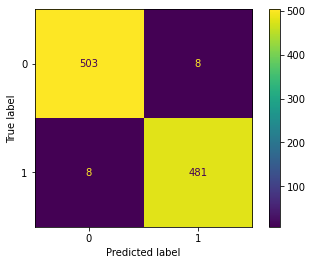

In [25]:
y_preds = df_test['pred']
y_test = df_test['y_true']
accuracy_score(y_true, y_pred)

ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

print(classification_report(y_test, y_preds, target_names=target_names))

start = time.time()

df_test['pred'] = df_test['review_title'].apply(get_ensemble_sentiment)

end = time.time()

print(f"Total time to classify {len(X_test)} records: {end - start} seconds")
print(f"Time to classify each record: {((end - start)/len(X_test))} seconds")

In [26]:
# df_test.to_csv('hotel_reviews_prediction.csv', index=False)

In [27]:
unique_terms = set()
df_data['review_title'].str.lower().str.split().apply(unique_terms.update)

20       None
24       None
39       None
47       None
60       None
         ... 
5426     None
714      None
24167    None
17376    None
22607    None
Name: review_title, Length: 3472, dtype: object

In [30]:
word = 'contented'

print(f"'{word}' in dictionary: {word in unique_terms}")

print(get_sentiment(lr_model, word), '\n')

word = 'detriment'

print(f"'{word}' in dictionary: {word in unique_terms}")

print(get_sentiment(lr_model, word))

'contented' in dictionary: False
('Negative', 0.6502267202899557) 

'detriment' in dictionary: False
('Negative', 0.6502267202899557)
